# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('dark_background')

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [203]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [204]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [205]:
set(y_random)

{0.5}

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: кажется мы предсказываем не классы, а вероятности нахождения в классах, что есть дробное число

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [206]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


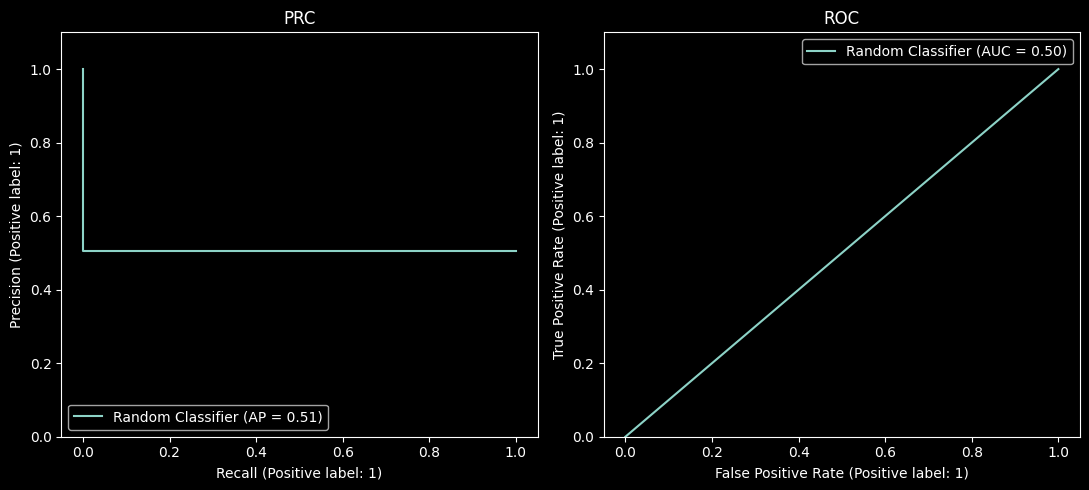

In [207]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [208]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [209]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

c_values = np.logspace(-3, 0, 20)

linear_svc = GridSearchCV(
    estimator=LinearSVC(max_iter=2**31-1),
    param_grid={'C': c_values},
    scoring='average_precision'
)

linear_svc.fit(X_train, y_train)
linear_svc.best_params_['C']

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

0.0379269019073225

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Linear SVC metrics
AUC-PR: 0.82966
AUC-ROC: 0.84764


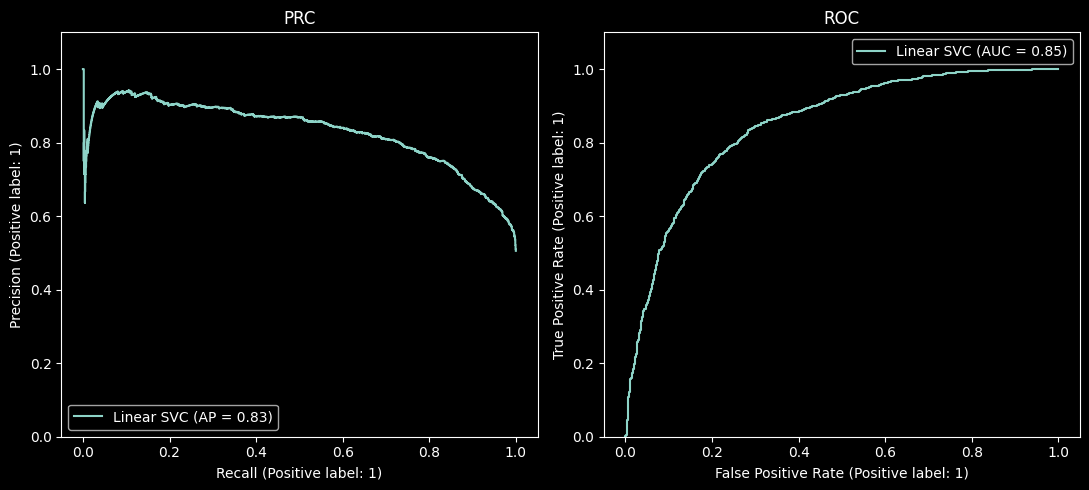

In [210]:
predictions = linear_svc.decision_function(X_test)

depict_pr_roc(y_test, predictions, 'Linear SVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

#your code here

auc-roc и auc-pr сильно больше, чем на случайном классификаторе что говорит о том, что мы начинаем разделять объекты на классы..


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [211]:
from sklearn.linear_model import LogisticRegression

c_values = np.logspace(-3, 0, 20)

logistic_regression = GridSearchCV(
    estimator=LogisticRegression(max_iter=2**31-1, penalty="l2"),
    param_grid={'C': c_values},
    scoring='average_precision'
)

logistic_regression.fit(X_train, y_train)
logistic_regression.best_params_['C']

0.001

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Logistic Regression metrics
AUC-PR: 0.82966
AUC-ROC: 0.84764


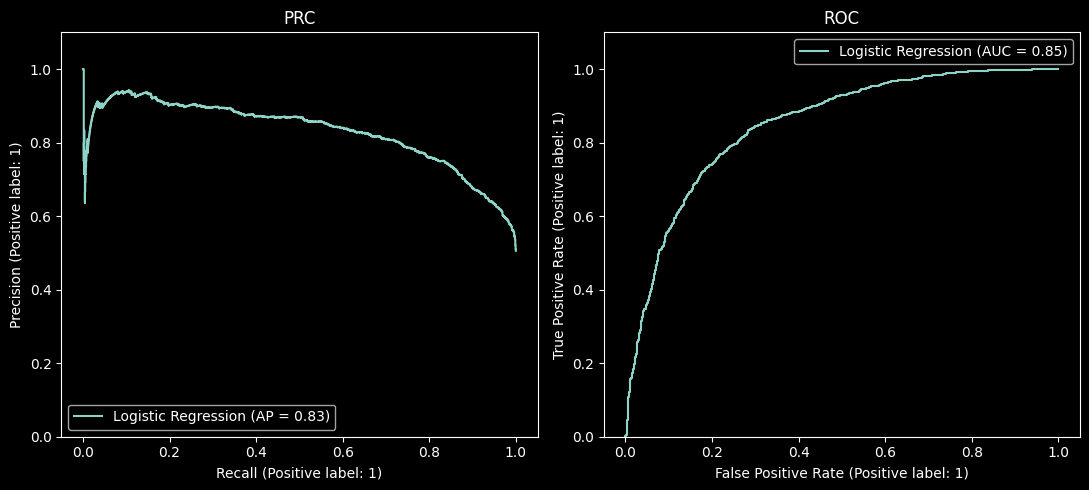

In [212]:
predictions = linear_svc.decision_function(X_test)

depict_pr_roc(y_test, predictions, 'Logistic Regression')

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** как-то auc-roc и auc-pr слишком похожи, значит в данных нет ничего такого, что портило бы одну из моделей, а именно - выбросов (если бы были, качество на svm было бы сильно лучше)

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [213]:
#your code here
from sklearn.svm import SVC

X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = SVC(kernel='linear')
model.fit(X, y)


SVC(kernel='linear')

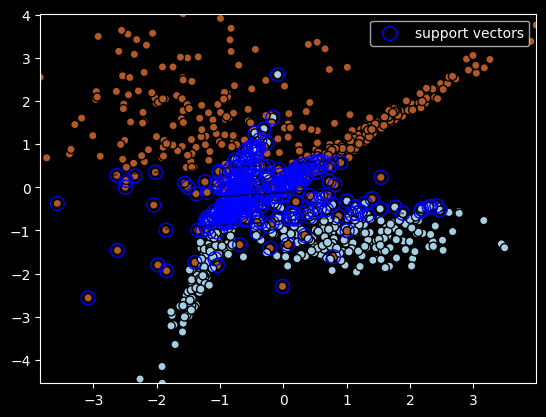

In [214]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(x=model.support_vectors_[:, 0], y=model.support_vectors_[:, 1],
                    label='support vectors',
                    s=100,
                    linewidth=1,
                    edgecolor="blue",
                    facecolors='none')

    plt.legend()


plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорные векторы - это объекты обучающей выборки, которые влияют на разделяющую гиперплоскость в SVM. Они находятся ближе всего к разделяющей границе и влияют на её положение и направление. Опорными векторами могут быть точки, которые лежат на границе или находятся на неправильной стороне границы классификации.



В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [215]:
lr = LogisticRegression(C=logistic_regression.best_params_['C'], penalty="l2")
lr.fit(X, y)

LogisticRegression(C=0.001)

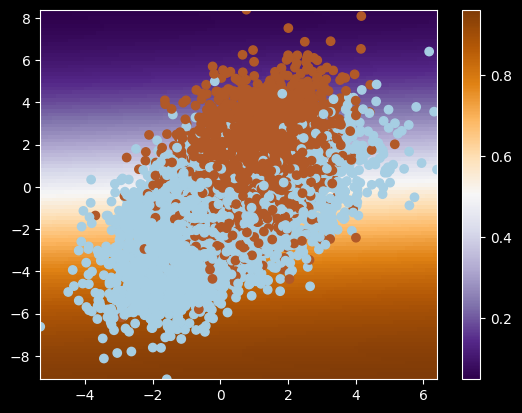

In [216]:


def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 0]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X_train[:,0], X_train[:,1], c=[pred for pred in y],
        cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X_train, y_train, lr)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** на графике - белый цвет, по смыслу - прямая

прямая так как признака 2

Мы хотим найти область, где $p(y=+1|x)=0.5$, или  $(w_0 + w_1 x_1 + w_2 x_2) = 0$

Если мы решим уравнение $(w_0 + w_1 x_1 + w_2 x_2) = 0$ относительно, например, $x_2$, мы получим:

$$x_2 = -\frac{w_0}{w_2} -\frac{w_1}{w_2} x_1 = a + b x_1$$

где $a = -\frac{w_0}{w_2}$ и $b = -\frac{w_1}{w_2}$. Уравнение представляет собой уравнение прямой.



#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [217]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios, label=name, color='blue')
    plt.plot([0, 1], [0, 1], label='Perfect', color='red')
    plt.ylim([-0.05, 1.05])

    plt.title(name)
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [218]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [219]:
lr = LogisticRegression(C=logistic_regression.best_params_['C'], penalty="l2")
lr.fit(X_train, y_train)
lr_pred = lr.predict_proba(X_test)[:, 1]

In [220]:
svc = LinearSVC(max_iter=2**31-1, C=linear_svc.best_params_['C'])
svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


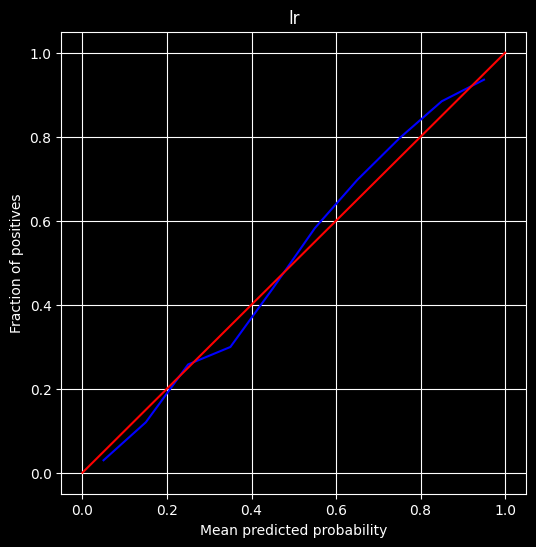

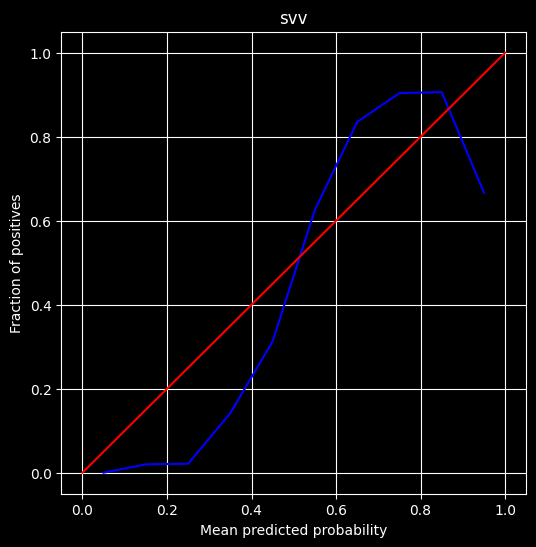

In [221]:
plt.figure(figsize=(6, 6))
plot_calibration_curve(y_test, lr_pred, "lr")
plt.show()

plt.figure(figsize=(6, 6))
plot_calibration_curve(y_test, svc_pred, "svv")

plt.show()


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** LR откалибрована хорошо (кривая близко к диагонали), у SVM все грустно

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

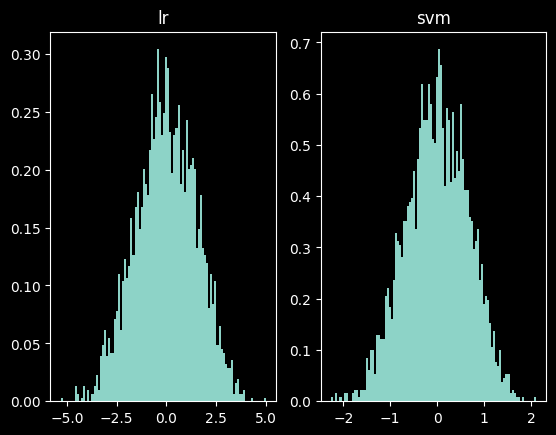

In [222]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(lr.decision_function(X_test), bins = 100, density='True')
axs[1].hist(svc.decision_function(X_test), bins = 100, density='True')
axs[0].set_title('lr')
axs[1].set_title('svm')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** несмотря на то чо распределение ответов классификаторов похожее, видно что lr предсказывает лучше

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  war

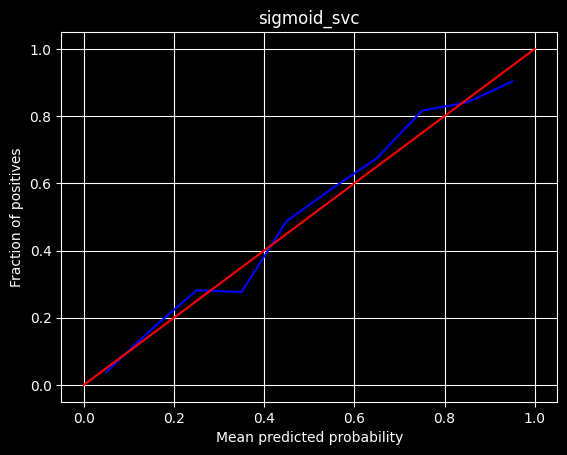

In [223]:
#your code here
from sklearn.calibration import CalibratedClassifierCV

sigmoid_svc = CalibratedClassifierCV(svc)
sigmoid_svc.fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, sigmoid_svc_pred, 'sigmoid_svc')

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [224]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [225]:
df = pd.read_csv('data/bike_buyers.csv')

In [226]:
df.columns, df.dtypes

(Index(['ID', 'Marital Status', 'Gender', 'Income', 'Children', 'Education',
        'Occupation', 'Home Owner', 'Cars', 'Commute Distance', 'Region', 'Age',
        'Purchased Bike'],
       dtype='object'),
 ID                    int64
 Marital Status       object
 Gender               object
 Income              float64
 Children            float64
 Education            object
 Occupation           object
 Home Owner           object
 Cars                float64
 Commute Distance     object
 Region               object
 Age                 float64
 Purchased Bike       object
 dtype: object)

In [227]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [228]:

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# drop rows containing NaNs in any column
df.dropna(inplace=True)

# optional: reset the index if needed
df.reset_index(drop=True, inplace=True)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
numerical = list(filter(lambda x: X[x].dtype != object, X.columns.to_list()))
categorical = list(filter(lambda x: X[x].dtype == object, X.columns.to_list()))

X_numerical = X[numerical]
X_categorical = X[categorical]


В начале поработаем только с категориальными признаками


In [229]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [230]:
quality = {}

In [231]:
def print_quality_stats():
    for enc_name, values in quality.items():
        print(enc_name)
        for val_name, val in values.items():
            print(f"{val_name} - {val}")
        print("----")

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [232]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

start_time = time.time()
column_transformer = ColumnTransformer([
    ('OrdinalEncoder', OrdinalEncoder(), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])

lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_ord = average_precision_score(y_test, y_test_pred)
training_time_ord = time.time() - start_time

print("AUC-PR score:", auc_pr_ord)
print("Training time:", training_time_ord)
quality["Ordinal"] =  {"time": training_time_ord, "auc-pr": auc_pr_ord}

AUC-PR score: 0.5414620145617135
Training time: 0.006670713424682617


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [233]:
import time
from sklearn.preprocessing import OneHotEncoder

start_time = time.time()
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])

lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_ohe = average_precision_score(y_test, y_test_pred)
training_time_ohe = time.time() - start_time

print("AUC-PR score:", auc_pr_ohe)
print("Training time:", training_time_ohe)
quality["OneHot"] =  {"time": training_time_ohe, "auc-pr": auc_pr_ohe}

AUC-PR score: 0.582919827038612
Training time: 0.007911205291748047


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [234]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical, noise=None, smoothing=10):
        self.categorical = categorical
        self.noise = noise
        self.smoothing = smoothing

    def fit(self, X, y):
        X_copy = X.copy()
        X_copy['target'] = y
        self._counters = {}
        self._global_mean = y.mean()
        for feature in self.categorical:
            mean_per_category = X_copy.groupby(feature)['target'].mean()
            category_size = X_copy.groupby(feature)['target'].count()
            self._counters[feature] = (mean_per_category * category_size + self._global_mean * self.smoothing) / (category_size + self.smoothing)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for feature in self.categorical:
            X_copy[feature] = X_copy[feature].map(self._counters[feature])
            if self.noise:
                X_copy[feature] += np.random.normal(scale=self.noise, size=X_copy.shape[0])
        return X_copy


In [235]:
start_time = time.time()
column_transformer = ColumnTransformer([
    ('MeanTargetEncoder', MeanTargetEncoder(categorical), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])

lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_mte = average_precision_score(y_test, y_test_pred)
training_time_mte = time.time() - start_time

print("AUC-PR score:", auc_pr_mte)
print("Training time:", training_time_mte)
quality["MeanTarget"] = {"time": training_time_mte, "auc-pr": auc_pr_mte}

AUC-PR score: 0.6013867589230777
Training time: 0.009991884231567383


In [236]:
print_quality_stats()

Ordinal
time - 0.006670713424682617
auc-pr - 0.5414620145617135
----
OneHot
time - 0.007911205291748047
auc-pr - 0.582919827038612
----
MeanTarget
time - 0.009991884231567383
auc-pr - 0.6013867589230777
----


По качеству лучше всего mte, по времени лучше всего ord, у ord худшее качество


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [237]:
#your code here
import numpy as np
noises = np.arange(0.001, 0.5+0.001, 0.001)

best_noise, best_noise_auc, best_noise_time = None, 0, None
for noise in noises:
    start_time = time.time()
    column_transformer = ColumnTransformer([
        ('MeanTargetEncoder', MeanTargetEncoder(categorical, noise), categorical),
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
    ])

    lr = lr_pipeline.fit(X_train, y_train)
    y_test_pred = lr.decision_function(X_test)

    auc_pr_mte_noise = average_precision_score(y_test, y_test_pred)
    training_time_mte_noise = time.time() - start_time
    if best_noise_auc < auc_pr_mte_noise:
        best_noise_time = training_time_mte_noise
        best_noise_auc = auc_pr_mte_noise
        best_noise = noise

print("AUC-PR score:", best_noise_auc)
print("Training time:", best_noise_time)
print("Best noise:", best_noise)
quality["MeanTargetWithNoise"] = {"time": best_noise_time, "auc-pr": best_noise_auc, "best noise": best_noise}

AUC-PR score: 0.6283619592421852
Training time: 0.01180577278137207
Best noise: 0.084


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** немного помогло, auc_pr выросло; но незначительно => сильного переобучения не было

In [238]:
best_noise_auc - auc_pr_mte

0.026975200319107495

In [239]:
print_quality_stats()

Ordinal
time - 0.006670713424682617
auc-pr - 0.5414620145617135
----
OneHot
time - 0.007911205291748047
auc-pr - 0.582919827038612
----
MeanTarget
time - 0.009991884231567383
auc-pr - 0.6013867589230777
----
MeanTargetWithNoise
time - 0.01180577278137207
auc-pr - 0.6283619592421852
best noise - 0.084
----


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [240]:
#your code here


#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [241]:
#your code here
#your code here
import numpy as np
smoothes = np.arange(-1, 10, 0.5)

best_smooth, best_smooth_auc, best_smooth_time = None, 0, None
for smooth in smoothes:
    start_time = time.time()
    column_transformer = ColumnTransformer([
        ('MeanTargetEncoder', MeanTargetEncoder(categorical, best_noise, smooth), categorical),
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
    ])

    lr = lr_pipeline.fit(X_train, y_train)
    y_test_pred = lr.decision_function(X_test)

    auc_pr_mte_noise_sm = average_precision_score(y_test, y_test_pred)
    training_time_mte_noise_sm = time.time() - start_time
    if best_smooth_auc < auc_pr_mte_noise_sm:
        best_smooth_time = training_time_mte_noise_sm
        best_smooth_auc = auc_pr_mte_noise_sm
        best_smooth = smooth

print("AUC-PR score:", best_smooth_auc)
print("Training time:", best_smooth_time)
print("Best c:", best_smooth)
quality["MeanTargetWithSmoothing"] = {"time": best_smooth_time, "auc-pr": best_smooth_auc, "best с": best_smooth}

AUC-PR score: 0.6170032285047544
Training time: 0.008368253707885742
Best c: 7.0


In [242]:
print_quality_stats()

Ordinal
time - 0.006670713424682617
auc-pr - 0.5414620145617135
----
OneHot
time - 0.007911205291748047
auc-pr - 0.582919827038612
----
MeanTarget
time - 0.009991884231567383
auc-pr - 0.6013867589230777
----
MeanTargetWithNoise
time - 0.01180577278137207
auc-pr - 0.6283619592421852
best noise - 0.084
----
MeanTargetWithSmoothing
time - 0.008368253707885742
auc-pr - 0.6170032285047544
best с - 7.0
----


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [243]:
for col in numerical:
    col_mean = np.mean(df[col])
    df[col].fillna(col_mean, inplace=True)

df.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Purchased Bike      0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [244]:
# сколько?
{col: df[col].nunique() for col in numerical}

{'ID': 952, 'Income': 16, 'Children': 6, 'Cars': 5, 'Age': 52}

Хочется дропнуть ID - оно ничего не значит

In [245]:
df = df.drop('ID', axis=1)
df.head()

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
4,Married,Female,10000.0,2.0,Partial College,Manual,Yes,0.0,1-2 Miles,Europe,50.0,No


In [246]:
numerical.remove('ID')
numerical

['Income', 'Children', 'Cars', 'Age']

In [249]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


In [257]:
sorted(X_train['Income'].unique())

[10000.0,
 20000.0,
 30000.0,
 40000.0,
 50000.0,
 60000.0,
 70000.0,
 80000.0,
 90000.0,
 100000.0,
 110000.0,
 120000.0,
 130000.0,
 150000.0,
 160000.0,
 170000.0]

In [258]:
sorted(y_test.unique())

[0, 1]

In [260]:
print(df.isna().sum())
print(df.dtypes)


Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
Purchased Bike      0
dtype: int64
Marital Status       object
Gender               object
Income              float64
Children            float64
Education            object
Occupation           object
Home Owner           object
Cars                float64
Commute Distance     object
Region               object
Age                 float64
Purchased Bike       object
dtype: object


сразу буду подбирать и шум и c для сглаживания

Кодируем все вместе:

In [263]:
ct_mean_target = ColumnTransformer(
    transformers=[
        (
            "all",
            MeanTargetEncoder(numerical + categorical, smoothing=100, noise=0.01),
            numerical + categorical,
        ),
    ]
)

logreg_pipeline = Pipeline([("preprocessor", ct_mean_target), ("logreg", LogisticRegression())])
start_time = time.time()
logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('all',
                                                  MeanTargetEncoder(categorical=['Income',
                                                                                 'Children',
                                                                                 'Cars',
                                                                                 'Age',
                                                                                 'Marital '
                                                                                 'Status',
                                                                                 'Gender',
                                                                                 'Education',
                                                                                 'Occupation',
                                                                                 'Home '
                                                                                 'Owner',
                                                                                 'Commute '
                                                                                 'Distance',
                                                                                 'Region'],
                                                                    noise=0.01,
                                                                    smoothing=100),
                                                  ['Income', 'Children', 'Cars',
                                                   'Age', 'Marital Status',
                                                   'Gender', 'Education',
                                                   'Occupation', 'Home Owner',
                                                   'Commute Distance',
                                                   'Region'])])),
                ('logreg', LogisticRegression())])

In [268]:
#your code here
noises = np.arange(0.001, 0.5+0.001, 0.001)
smoothes = np.arange(0, 100, 5)
all_best_noise, all_best_auc, all_best_time, all_best_c = None, 0, None, None
for noise in noises:
    for smooth in smoothes:
        start_time = time.time()
        column_transformer = ColumnTransformer([
            ('MeanTargetEncoder', MeanTargetEncoder(categorical + numerical, noise, smooth), categorical + numerical),
        ])
    
        lr_pipeline = Pipeline([
            ('ColumnTransformer', column_transformer),
            ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
        ])
    
        lr = lr_pipeline.fit(X_train, y_train)
        y_test_pred = lr.decision_function(X_test)

        auc_pr_cur = average_precision_score(y_test, y_test_pred)
        training_time_cur = time.time() - start_time
        if best_noise_auc < auc_pr_cur:
            all_best_c = smooth
            all_best_time = training_time_cur
            all_best_auc = auc_pr_cur
            all_best_noise = noise

print("AUC-PR score:", all_best_auc)
print("Training time:", all_best_time)
print("Best noise:", all_best_noise)
print("Best C:", all_best_c)

AUC-PR score: 0.6292959424507182
Training time: 0.008513212203979492
Best noise: 0.494
Best C: 10


а теперь кодируем по отдельности

In [270]:
#your code here
noises = np.arange(0.001, 0.5+0.001, 0.001)
smoothes = np.arange(0, 100, 5)
all_best_noise, all_best_auc, all_best_time, all_best_c = None, 0, None, None
for noise in noises:
    for smooth in smoothes:
        start_time = time.time()
        column_transformer = ColumnTransformer([
            ('MeanTargetEncoderCat', MeanTargetEncoder(categorical, noise, smooth), categorical),
            ('MeanTargetEncoderNum', MeanTargetEncoder(numerical, noise, smooth), numerical),
        ])

        lr_pipeline = Pipeline([
            ('ColumnTransformer', column_transformer),
            ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
        ])

        lr = lr_pipeline.fit(X_train, y_train)
        y_test_pred = lr.decision_function(X_test)

        auc_pr_cur = average_precision_score(y_test, y_test_pred)
        training_time_cur = time.time() - start_time
        if best_noise_auc < auc_pr_cur:
            all_best_c = smooth
            all_best_time = training_time_cur
            all_best_auc = auc_pr_cur
            all_best_noise = noise

print("AUC-PR score:", all_best_auc)
print("Training time:", all_best_time)
print("Best noise:", all_best_noise)
print("Best C:", all_best_c)

AUC-PR score: 0.6347666743084632
Training time: 0.012077808380126953
Best noise: 0.40700000000000003
Best C: 25


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

плюсы (почему счетчики > ohe)
- плохая сложность по памяти/ времени - для каждого признака + столбец

минусы (почему ohe > счетчики) - на признаках с маленьким множеством значений прирост по времени не так важен

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [271]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-26 15:06:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [       <=>          ]   3.79M  2.19MB/s    in 1.7s    

2023-11-26 15:06:35 (2.19 MB/s) - ‘adult.data’ saved [3974305]



In [273]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('data/adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20901,22,Private,198244,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,39,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [274]:
#your code here
features = [
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country'
]

X_train, X_test, y_train, y_test = train_test_split(df[features], df['income'], test_size=0.25, random_state=777, stratify=df['income'])

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [279]:
#your code here
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country', 'sex']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

OneHotEncoder().fit_transform(X_train[categorical]).shape[1] - X_train.shape[1]

88

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [283]:
from sklearn.preprocessing import StandardScaler

column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])

lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_start = average_precision_score(y_test, y_test_pred)

print(f'Test AUC-PR score: {auc_pr_start}')

Test AUC-PR score: 0.7671984012581696


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [286]:
class СutCoefs(BaseEstimator, TransformerMixin):
    def __init__(self, coefs, n):
        self.coefs = coefs
        self.n = n
        self.topn_coef_indecies = (-np.abs(coefs)).argsort()[:n]

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy[:, self.topn_coef_indecies]

In [284]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('top_n', СutCoefs(lr['LogisticRegression'].coef_[0], 40)),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])

lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_top40 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40}')

Test AUC-PR score: 0.7325530291853566


Изменилось ли качество? Как? ухудшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [285]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_start_1 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_start_1}')

Test AUC-PR score: 0.6855166930277108


In [291]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('top_n', СutCoefs(lr['LogisticRegression'].coef_[0], 40)),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_top40_1 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40_1}')

Test AUC-PR score: 0.6699649802915177


качество все еще теряем, но меньше

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [294]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(sparse=False), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('scaling', StandardScaler()),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_start_2 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_start_2}')

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test AUC-PR score: 0.6841157525386472


In [296]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(sparse=False), categorical),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('top_n', СutCoefs(lr['LogisticRegression'].coef_[0], 40)),
    ('scaling', StandardScaler()),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_top40_2 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40_2}')

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test AUC-PR score: 0.6766146549243253


качество хуже, можно было бы и не нормировать

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [297]:
#your code here
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_start_3 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_start_3}')

Test AUC-PR score: 0.7671984012581696


In [300]:
class СutCoefsSmart(BaseEstimator, TransformerMixin):
    def __init__(self, n):
        self.n = n

    def fit(self, X, y):
        num_features = X.shape[1]
        stats = []
    
        y1_indices = np.where(y == 1)[0]
        y0_indices = np.where(y == 0)[0]
    
        for i in range(num_features):
            X_y1 = X[y1_indices, i]
            X_y0 = X[y0_indices, i]
    
            mean_diff = abs(X_y1.mean() - X_y0.mean())
    
            weighted_std_sum = (X_y1.size * np.std(X_y1) ** 2) + (X_y0.size * np.std(X_y0) ** 2)
    
            stat = mean_diff / np.sqrt(weighted_std_sum / num_features)
            stats.append(stat)
    
        self.topn_coef_indices = (-np.abs(stats)).argsort()[:self.n]
        return self


    def transform(self, X, y=None):
        X_copy = X.copy()
        return X_copy[:, self.topn_coef_indices]

In [301]:
column_transformer = ColumnTransformer([
    ('OneHotEncoder', OneHotEncoder(sparse=False), categorical),
    ('scaling', StandardScaler(), numeric),
])

lr_pipeline = Pipeline([
    ('ColumnTransformer', column_transformer),
    ('FilterMethod', СutCoefsSmart(40)),
    ('LogisticRegression', LogisticRegression(max_iter=2**31-1, penalty="l2"))
])
lr = lr_pipeline.fit(X_train, y_train)
y_test_pred = lr.decision_function(X_test)

auc_pr_top40_3 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40_3}')

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test AUC-PR score: 0.7620529716807395


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [302]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('OneHotEncoder', OneHotEncoder(sparse=False), categorical),
]).fit(X_train)

X_train_transformed = pd.DataFrame(column_transformer.transform(X_train))
X_test_transformed = pd.DataFrame(column_transformer.transform(X_test))

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train_transformed, y_train, test_size=0.3, random_state=42)

/Users/onikovad/Library/Python/3.11/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [303]:
def remove_worst_column(X_train1, X_train2, y_train1, y_train2):
    column_scores = {}
    lr = LogisticRegression(max_iter=2**31-1, penalty="l2")

    for col_name in X_train1.columns:
        X_train1_dropped = X_train1.drop(col_name, axis=1)
        lr.fit(X_train1_dropped, y_train1)

        y_test_pred = lr.decision_function(X_train2.drop(col_name, axis=1))
        column_scores[col_name] = average_precision_score(y_train2, y_test_pred)

    worst_column = max(column_scores, key=column_scores.get)
    return X_train1.drop(worst_column, axis=1), X_train2.drop(worst_column, axis=1)

start = time.time()
while X_train1.shape[1] != 40:
    X_train1, X_train2 = remove_worst_column(X_train1, X_train2, y_train1, y_train2)


time_1 = time.time() - start
print(f"Duration {time_1}")

Duration 2315.1757848262787


In [304]:
lr = LogisticRegression(max_iter=2**31-1, penalty="l2").fit(X_train1, y_train1)
y_test_pred = lr.decision_function(X_test_transformed[X_train1.columns])

auc_pr_top40_4 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40_4}')

Test AUC-PR score: 0.7674395616828287


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('OneHotEncoder', OneHotEncoder(sparse=False), categorical),
]).fit(X_train)

X_train_transformed = pd.DataFrame(column_transformer.transform(X_train))
X_test_transformed = pd.DataFrame(column_transformer.transform(X_test))

X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train_transformed, y_train, test_size=0.3, random_state=42)

In [305]:


def evaluate_column_performance(selected_columns, X_train1, X_train2, y_train1, y_train2):
    column_scores = {}
    lr = LogisticRegression(max_iter=2**31-1, penalty="l2")

    for col_name in selected_columns:
        current_columns = selected_columns.copy()
        current_columns.append(col_name)

        lr.fit(X_train1[current_columns], y_train1)
        y_test_pred = lr.decision_function(X_train2[current_columns])

        column_scores[col_name] = average_precision_score(y_train2, y_test_pred)

    return column_scores

def select_best_columns(X_train1, X_train2, y_train1, y_train2, num_columns=40):
    selected_columns = []
    not_selected_columns = list(X_train1.columns)

    while len(selected_columns) != num_columns:
        column_scores = evaluate_column_performance(not_selected_columns, X_train1, X_train2, y_train1, y_train2)
        best_column = max(column_scores, key=column_scores.get)

        selected_columns.append(best_column)
        not_selected_columns.remove(best_column)

    return selected_columns

start = time.time()
selected_columns = select_best_columns(X_train1, X_train2, y_train1, y_train2)
time_2 = time.time() - start
time_2


131.0763750076294

In [306]:
lr = LogisticRegression(max_iter=2**31-1, penalty="l2").fit(X_train1, y_train1)
y_test_pred = lr.decision_function(X_test_transformed[X_train1.columns])

auc_pr_top40_5 = average_precision_score(y_test, y_test_pred)
print(f'Test AUC-PR score: {auc_pr_top40_5}')

Test AUC-PR score: 0.7674395616828287


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Лучшее качество было достигнуто при постепенном исключении одного признака за раз.

Однако, поиск 40 наиболее значимых признаков, исключая их по одному, является очень медленным процессом, особенно когда у нас очень много признаков, так как это потребует обучения тысяч моделей (что занимает очень много времени). Вместе с тем, мы не замечаем особого прироста качества по сравнению с методом отбора признаков, в котором мы постепенно увеличиваем количество признаков.



# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [330]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

In [331]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [332]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [333]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

numeric = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
categorical = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [334]:
from sklearn.metrics import accuracy_score

for train_index, val_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_val, y_val = X.iloc[val_index], y[val_index]

    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric),
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    lr = lr_pipeline.fit(X_train, y_train)
    y_val_pred = lr.predict(X_val)

    score = accuracy_score(y_val, y_val_pred)
    print(f'Test accuracy score: {score}')

Test accuracy score: 0.9036173828599174
Test accuracy score: 0.8997329448895363
Test accuracy score: 0.8969410050983249
Test accuracy score: 0.9074905912346728
Test accuracy score: 0.8907369187811096


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [335]:
def create_lr_pipeline(categorical, numeric):
    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric)
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    return lr_pipeline

def calculate_profit(y_val_pred, y_val):
    return np.sum((y_val_pred & y_val) * np.random.randint(0, 20, size=len(y_val_pred)))


salary = []
profit = []

for train_index, val_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_val, y_val = X.iloc[val_index], y[val_index]

    lr_pipeline = create_lr_pipeline(categorical, numeric)
    lr = lr_pipeline.fit(X_train, y_train)
    y_val_pred = lr.predict(X_val)

    salary.append(np.sum(y_val_pred))
    profit.append(calculate_profit(y_val_pred, y_val))



In [336]:
print(f"В среднем заработаем: {np.mean(profit)}")
print(f"среднее количество денег, которые придется отдать операторам: {np.mean(salary)}")
print(f"Выручка в среднем: {np.mean(np.array(profit) - np.array(salary))}")
print(f"Стандартное отклонение выручки: {np.std(np.array(profit) - np.array(salary))}")

В среднем заработаем: 2079.4
среднее количество денег, которые придется отдать операторам: 324.2
Выручка в среднем: 1755.2
Стандартное отклонение выручки: 145.40206325908858


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [337]:

def create_lr_pipeline(categorical, numeric):
    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric),
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    return lr_pipeline

def calculate_profit(y_val_pred, y_val):
    return np.sum((y_val_pred & y_val) * np.random.randint(0, 20, size=len(y_val_pred)))

def evaluate_pipeline(X, y, kf, categorical, numeric):
    salary = []
    profit = []

    for train_index, val_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_val, y_val = X.iloc[val_index], y[val_index]

        lr_pipeline = create_lr_pipeline(categorical, numeric)
        lr = lr_pipeline.fit(X_train, y_train)
        y_val_pred = lr.predict(X_val)

        salary.append(np.sum(y_val_pred))
        profit.append(calculate_profit(y_val_pred, y_val))

    return salary, profit

salary, profit = evaluate_pipeline(X, y, kf, categorical, numeric)


In [338]:
print(f"В среднем заработаем: {np.mean(profit)}")
print(f"среднее количество денег, которые придется отдать операторам: {np.mean(salary)}")
print(f"Выручка в среднем: {np.mean(np.array(profit) - np.array(salary))}")
print(f"Стандартное отклонение выручки: {np.std(np.array(profit) - np.array(salary))}")

В среднем заработаем: 2089.4
среднее количество денег, которые придется отдать операторам: 324.2
Выручка в среднем: 1765.2
Стандартное отклонение выручки: 53.12400587305141


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [339]:

from sklearn.metrics import make_scorer


def my_scoring(pred, target):
    return np.sum((pred & target) * np.random.randint(0, 20, size=len(pred)))

def create_column_transformer(categorical, numeric):
    return ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric),
    ])

def build_lr_pipeline_with_grid_search(column_transformer, c_values, kf):
    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    grid_search = GridSearchCV(
        estimator=lr_pipeline,
        param_grid={'LogisticRegression__C': c_values},
        scoring=make_scorer(my_scoring, greater_is_better=False),
        cv=kf,
    )
    return grid_search

c_values = np.logspace(-3, 0, 20)

column_transformer = create_column_transformer(categorical, numeric)
grid_search = build_lr_pipeline_with_grid_search(column_transformer, c_values, kf)

grid_search.fit(X_train, y_train)
print("Best alpha: ", grid_search.best_params_["LogisticRegression__C"])


Best alpha:  0.0014384498882876629


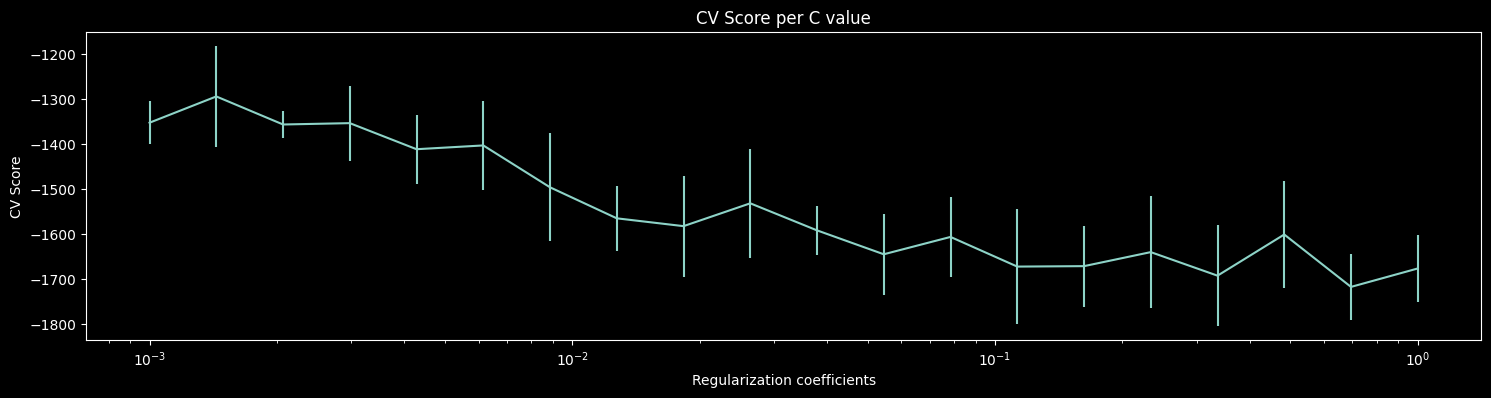

In [341]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.errorbar(x=c_values, y=grid_search.cv_results_["mean_test_score"], yerr=grid_search.cv_results_['std_test_score'])
ax.set_xscale("log")
ax.set_xlabel('Regularization coefficients')
ax.set_ylabel('CV Score')
ax.set_title('CV Score per C value')

plt.show()


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [345]:

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

def create_column_transformer(categorical, numeric):
    return ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric),
    ])

def build_lr_pipeline_with_grid_search(column_transformer, c_values, kf):
    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1)),
    ])

    grid_search = GridSearchCV(
        estimator=lr_pipeline,
        param_grid={'LogisticRegression__C': c_values},
        scoring=make_scorer(my_scoring, greater_is_better=False),
        cv=kf,
    )
    return grid_search

def find_best_alpha(iterations, X_train, y_train, categorical, numeric, c_values, kf):
    for _ in range(iterations):
        column_transformer = create_column_transformer(categorical, numeric)
        grid_search = build_lr_pipeline_with_grid_search(column_transformer, c_values, kf)
        grid_search.fit(X_train, y_train)
        print("Best alpha: ", grid_search.best_params_["LogisticRegression__C"])

iterations = 7

c_values = np.logspace(-3, 0, 20)
find_best_alpha(iterations, X_train, y_train, categorical, numeric, c_values, kf)


Best alpha:  0.004281332398719396
Best alpha:  0.001
Best alpha:  0.0014384498882876629
Best alpha:  0.0014384498882876629
Best alpha:  0.002976351441631319
Best alpha:  0.004281332398719396
Best alpha:  0.0014384498882876629


я не вижу закономерностей, ну их и не должно быть, доход же случайный

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [348]:
def calculate_profits_and_salaries(X_train, y_train, X_val, y_val, categorical, numeric, threshold):
    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric),
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    lr = lr_pipeline.fit(X_train, y_train)

    predicted_probs = lr.predict_proba(X_val)[:, 1]
    y_val_pred = [1 if threshold < prob else 0 for prob in predicted_probs]

    salary = np.sum(y_val_pred)
    profit = np.sum((y_val_pred & y_val) * np.random.randint(0, 20, size=len(y_val_pred)))

    return profit, salary


def find_best_param(X, y, categorical, numeric, kf):
    best_param = 0
    best_profit = 0
    stds = []
    mean_profits = []

    for threshold in np.arange(0, 1, 0.01):
        profits = []
        salaries = []

        for train_index, val_index in kf.split(X):
            X_train, y_train = X.iloc[train_index], y[train_index]
            X_val, y_val = X.iloc[val_index], y[val_index]

            profit, salary = calculate_profits_and_salaries(X_train, y_train, X_val, y_val, categorical, numeric, threshold)

            profits.append(profit)
            salaries.append(salary)

        stds.append(np.std(np.array(profits) - np.array(salaries)))
        mean_profits.append(np.mean(np.array(profits) - np.array(salaries)))

        if best_profit < mean_profits[-1]:
            best_profit = mean_profits[-1]
            best_param = threshold

    return best_param, mean_profits, stds

best_param, mean_profits, stds = find_best_param(X, y, categorical, numeric, kf)
best_param

/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/97339273.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  profit = np.sum((y_val_pred & y_val) * np.random.randint(0, 20, size=len(y_val_pred)))
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/97339273.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  profit = np.sum((y_val_pred & y_val) * np.random.randint(0, 20, size=len(y_val_pred)))
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/97339273.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) ar

0.13

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




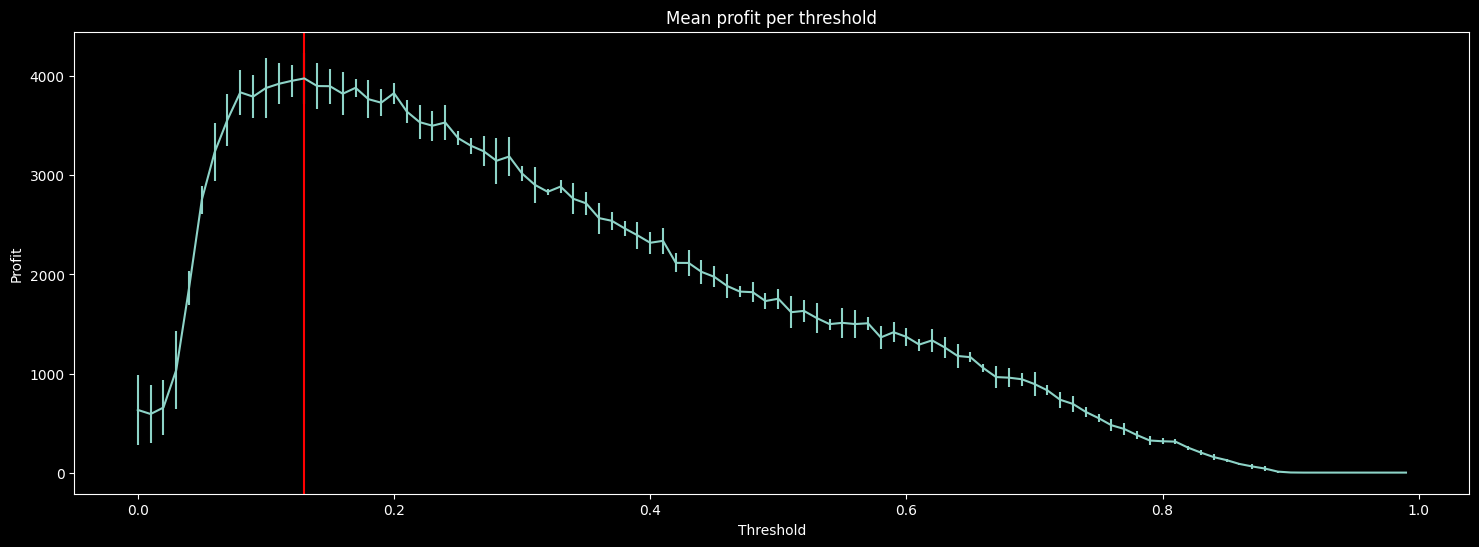

In [349]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.errorbar(x=np.arange(0, 1, 0.01), y=mean_profits, yerr=stds)
ax.axvline(x=best_param, c='red')
ax.set_xlabel('Threshold')
ax.set_ylabel('Profit')
ax.set_title('Mean profit per threshold')

plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ несколько запусков выдали что все пороги от 0.1 до 0.19 - объясняется единственностью оптимума функции

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [350]:
def calculate_precision_recall(X_train, y_train, X_val, y_val, categorical, numeric, best_param):
    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric)
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    lr = lr_pipeline.fit(X_train, y_train)

    predicted_probs = lr.predict_proba(X_val)[:, 1]
    y_val_pred = [1 if best_param < prob else 0 for prob in predicted_probs]

    precision = np.sum(y_val_pred & y_val) / np.sum(y_val_pred)
    recall = np.sum(y_val_pred & y_val) / np.sum(y_val)

    return precision, recall


def compute_precisions_and_recalls(X, y, categorical, numeric, kf, best_param):
    precisions = []
    recalls = []

    for train_index, val_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y[train_index]
        X_val, y_val = X.iloc[val_index], y[val_index]

        precision, recall = calculate_precision_recall(X_train, y_train, X_val, y_val, categorical, numeric, best_param)

        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

precisions, recalls = compute_precisions_and_recalls(X, y, categorical, numeric, kf, best_param)


/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/2771089667.py:17: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  precision = np.sum(y_val_pred & y_val) / np.sum(y_val_pred)
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/2771089667.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  recall = np.sum(y_val_pred & y_val) / np.sum(y_val)
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/2771089667.py:17: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap th

In [352]:
print(f"Средний precision: {np.mean(precisions)}")
print(f"Дисперсия precision: {np.std(precisions)}")
print(f"Средний recall: {np.mean(recalls)}")
print(f"Дисперсия recall: {np.std(recalls)}")

Средний precision: 0.37038659516385597
Дисперсия precision: 0.014839186762818495
Средний recall: 0.6142012287800267
Дисперсия recall: 0.021789125889096362


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [353]:
def calculate_mean_precisions_and_recalls(X_train, y_train, X_val, y_val, categorical, numeric, threshold):
    column_transformer = ColumnTransformer([
        ('OneHotEncoder', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('Scaling', StandardScaler(), numeric)
    ])

    lr_pipeline = Pipeline([
        ('ColumnTransformer', column_transformer),
        ('LogisticRegression', LogisticRegression(max_iter=2**31-1))
    ])

    lr = lr_pipeline.fit(X_train, y_train)

    predicted_probs = lr.predict_proba(X_val)[:, 1]
    y_val_pred = [1 if threshold < prob else 0 for prob in predicted_probs]

    precision = np.sum(y_val_pred & y_val) / np.sum(y_val_pred) if np.sum(y_val_pred) > 0 else 0
    recall = np.sum(y_val_pred & y_val) / np.sum(y_val)

    return precision, recall


def compute_mean_precisions_and_recalls(X, y, categorical, numeric, kf):
    mean_precisions = []
    mean_recalls = []

    for threshold in np.arange(0, 1, 0.01):
        precisions = []
        recalls = []

        for train_index, val_index in kf.split(X):
            X_train, y_train = X.iloc[train_index], y[train_index]
            X_val, y_val = X.iloc[val_index], y[val_index]

            precision, recall = calculate_mean_precisions_and_recalls(X_train, y_train, X_val, y_val, categorical, numeric, threshold)

            precisions.append(precision)
            recalls.append(recall)

        mean_precisions.append(np.mean(precisions))
        mean_recalls.append(np.mean(recalls))

    return mean_precisions, mean_recalls

mean_precisions, mean_recalls = compute_mean_precisions_and_recalls(X, y, categorical, numeric, kf)


/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/542350876.py:17: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  precision = np.sum(y_val_pred & y_val) / np.sum(y_val_pred) if np.sum(y_val_pred) > 0 else 0
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/542350876.py:18: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  recall = np.sum(y_val_pred & y_val) / np.sum(y_val)
/var/folders/4b/xvx63gm56k1_1g9rgfglm_p8jgqgmr/T/ipykernel_88251/542350876.py:17: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will rais

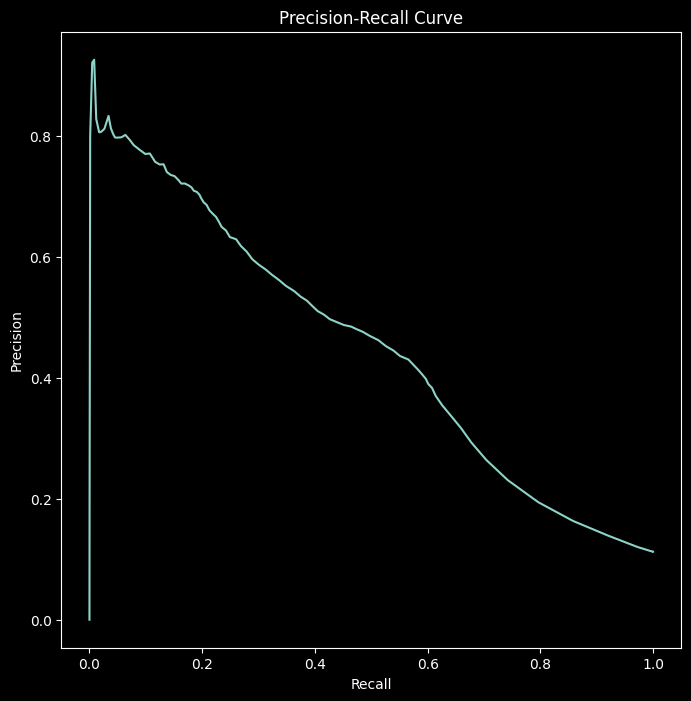

In [354]:
plt.subplots(figsize=(8, 8))
plt.plot(mean_recalls, mean_precisions)
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [355]:
# попробуем обрезать данные с recall < 0.5
def filter_mean_recalls_and_precisions(mean_recalls, mean_precisions, min_recall=0.5):
    new_mean_recalls = []
    new_mean_precisions = []

    for i, mean_recall in enumerate(mean_recalls):
        if mean_recall >= min_recall:
            new_mean_recalls.append(mean_recall)
            new_mean_precisions.append(mean_precisions[i])

    return new_mean_recalls, new_mean_precisions

new_mean_recalls, new_mean_precisions = filter_mean_recalls_and_precisions(mean_recalls, mean_precisions)


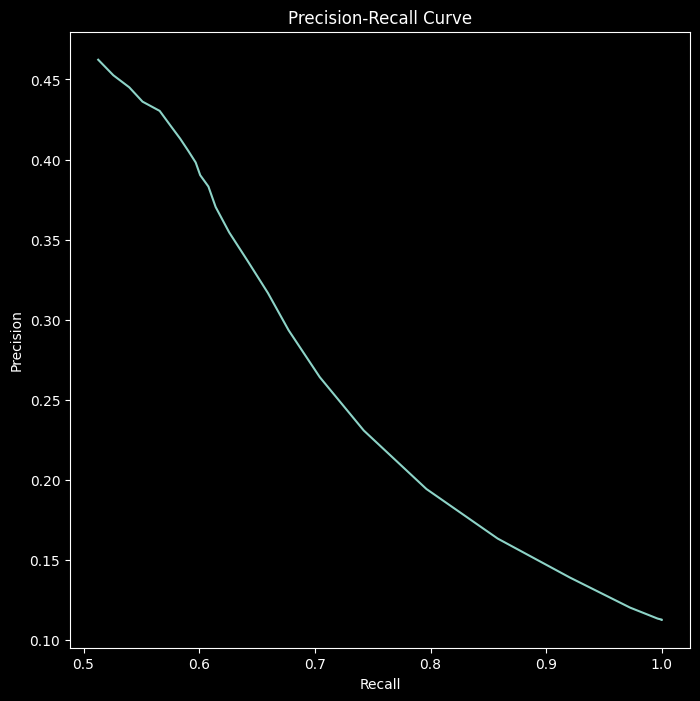

In [356]:
plt.subplots(figsize=(8, 8))
plt.plot(new_mean_recalls, new_mean_precisions)
plt.title('Precision-Recall Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [357]:
auc(new_mean_recalls,new_mean_precisions)

0.12297325967661252

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ завтраки для слабых